In [1]:
# To ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import the libraries to handle the np array and pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import py files
import acquire, prepare, explore

import psutil
from tqdm.notebook import tqdm
import gc

### Acquire and Prepare the Train/Validate/Test Dataset

In [2]:
%%time

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32"   
}

# Load train/validate/test
df_train = pd.read_csv("../Riiid-Project/sampled_trainset.csv", index_col=0, dtype=dtypes)
df_validate = pd.read_csv("../Riiid-Project/validate.csv", index_col=0, dtype=dtypes)
df_test = pd.read_csv("../Riiid-Project/test.csv", index_col=0, dtype=dtypes)

CPU times: user 45 s, sys: 4.12 s, total: 49.1 s
Wall time: 49.8 s


In [3]:
%%time

# Define the data types
dtypes = {
    "question_id": "int16", 
    "bundle_id": "int16",
    "correct_answer": "int8", 
    "part": "int8", 
    "tags": "object", 
    "tag_count": "int8"    
    }

# Load questions dataset
df_ques = pd.read_csv('questions_with_tag_counts.csv', index_col=0, dtype=dtypes)

CPU times: user 8.17 ms, sys: 5.25 ms, total: 13.4 ms
Wall time: 13.4 ms


In [4]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   content_type_id                 boolean
 3   task_container_id               int16  
 4   user_answer                     int8   
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  object 
 8   lecture_id                      float64
 9   tag                             float64
 10  lecture_part                    float64
 11  type_of                         object 
 12  question_id                     float64
 13  bundle_id                       float64
 14  correct_answer                  float64
 15  question_part                   float64
 16  tags                            object 
dtypes: boolean(1), float32

In [5]:
%%time

# Drop columns that are not needed

cols = ['lecture_id', 'tag', 'lecture_part','type_of', 'question_id', 'bundle_id', 
        'correct_answer', 'question_part', 'tags', 'content_type_id', 'user_answer']

df_train.drop(columns=cols, inplace=True)
df_validate.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

CPU times: user 492 ms, sys: 449 ms, total: 941 ms
Wall time: 1.03 s


In [6]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(1)
memory usage: 579.8+ MB


In [7]:
# Print the information of df_ques
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13523 entries, 0 to 13522
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
 5   tag_count       13523 non-null  int8  
dtypes: int16(2), int8(3), object(1)
memory usage: 303.7+ KB


In [8]:
%%time
# Drop lecture rows

mask = (df_train.answered_correctly != -1)
df_train = df_train[mask]

mask = (df_validate.answered_correctly != -1)
df_validate = df_validate[mask]

mask = (df_test.answered_correctly != -1)
df_test = df_test[mask]

CPU times: user 1.05 s, sys: 480 ms, total: 1.53 s
Wall time: 1.74 s


In [9]:
%%time

# Merge df_train and df_ques
df_train = df_train.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: float32(1), int16(4), int32(1), int8(4), object(2)
memory usage: 862.5+ MB
CPU times: user 3.05 s, sys: 982 ms, total: 4.04 s
Wall time: 4.05 s


In [12]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                               0
content_id                            0
task_container_id                     0
answered_correctly                    0
prior_question_elapsed_time       99720
prior_question_had_explanation    99720
question_id                           0
bundle_id                             0
correct_answer                        0
part                                  0
tags                                  1
tag_count                             0
dtype: int64

In [13]:
# Check the nulls in df_validate
df_validate.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [14]:
# Check the nulls in df_test
df_test.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [15]:
%%time

# Fill the missing value in col `prior_question_elapsed_time` with 0
df_train.prior_question_elapsed_time.fillna(0, inplace=True)

# Fill the missing value in col `prior_question_had_explanation` with False
df_train.prior_question_had_explanation.fillna(False, inplace=True)

# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: bool(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 725.3+ MB
CPU times: user 1.28 s, sys: 20.4 ms, total: 1.3 s
Wall time: 1.31 s


In [17]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              1
tag_count                         0
dtype: int64

In [18]:
# Release memory
print("Memory usage before running garbage collector: ", psutil.virtual_memory().percent)
gc.collect
print("Memory usage after: ", psutil.virtual_memory().percent)

Memory usage before running garbage collector:  60.9
Memory usage after:  60.9


In [57]:
# Concat the user_ques_acc to the df_test

user_ques_accuracy = explore.compute_user_ques_acc(df_train)
df_test = df_test.merge(user_ques_accuracy, how='left', 
                        left_on = ['user_id', 'content_id'], 
                        right_on = ['user_id', 'content_id'])

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   9 non-null      float16
dtypes: bool(1), float16(1), float64(1), int16(2), int64(3), int8(2), object(1)
memory usage: 5.8+ KB


In [58]:
# Concat the user_bundle_acc to the df_test

user_bundle_accuracy = explore.compute_user_bundle_acc(df_train)
df_test = df_test.merge(user_bundle_accuracy, how='left', 
                        left_on = ['user_id', 'bundle_id'], 
                        right_on = ['user_id', 'bundle_id'])

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   9 non-null      float16
 11  user_bundle_acc                 9 non-null      float16
dtypes: bool(1), float16(2), float64(1), 

In [59]:
# Concat the user_tags_acc to the df_test

user_tags_accuracy = explore.compute_user_tags_acc(df_train)
df_test = df_test.merge(user_tags_accuracy, how='left', 
                        left_on = ['user_id', 'tags'], 
                        right_on = ['user_id', 'tags'])

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   9 non-null      float16
 11  user_bundle_acc                 9 non-null      float16
 12  user_tags_acc                   51 n

In [60]:
# Concat the user_part_acc to the df_test

user_part_accuracy = explore.compute_user_part_acc(df_train)
df_test = df_test.merge(user_part_accuracy, how='left', 
                        left_on = ['user_id', 'part'], 
                        right_on = ['user_id', 'part'])

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   9 non-null      float16
 11  user_bundle_acc                 9 non-null      float16
 12  user_tags_acc                   51 n

In [61]:
# Concat the ques_acc to the df_test

ques_accuracy = explore.compute_ques_acc(df_train)
df_test = df_test.merge(ques_accuracy, how='left', on='content_id')

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   9 non-null      float16
 11  user_bundle_acc                 9 non-null      float16
 12  user_tags_acc                   51 n

In [62]:
# Fill the missing values with 0
df_test.fillna(0,inplace=True)

# Print the information of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         104 non-null    int64  
 1   content_id                      104 non-null    int64  
 2   task_container_id               104 non-null    int64  
 3   prior_question_elapsed_time     104 non-null    float64
 4   prior_question_had_explanation  104 non-null    bool   
 5   question_id                     104 non-null    int16  
 6   bundle_id                       104 non-null    int16  
 7   part                            104 non-null    int8   
 8   tags                            104 non-null    object 
 9   tag_count                       104 non-null    int8   
 10  user_ques_acc                   104 non-null    float16
 11  user_bundle_acc                 104 non-null    float16
 12  user_tags_acc                   104 

In [63]:
%%time

# Add new features
df_train = explore.merge_new_features(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71327 entries, 0 to 71326
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         71327 non-null  int32  
 1   content_id                      71327 non-null  int16  
 2   task_container_id               71327 non-null  int16  
 3   answered_correctly              71327 non-null  int8   
 4   prior_question_elapsed_time     71327 non-null  float32
 5   prior_question_had_explanation  71327 non-null  boolean
 6   question_id                     71327 non-null  int16  
 7   bundle_id                       71327 non-null  int16  
 8   part                            71327 non-null  int8   
 9   tags                            71327 non-null  object 
 10  tag_count                       71327 non-null  int8   
 11  user_ques_acc                   71327 non-null  float16
 12  user_bundle_acc                 

In [64]:
# Print first 5 rows of df_train
df_train.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,tag_count,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc
0,554169193,3927,0,1,0.0,False,3927,3927,5,79,1,1.0,1.0,0.580078,0.649902,0.649902,1.000000
1,554169193,939,1,1,23000.0,False,939,939,2,2 62 56 162 38 81,6,1.0,1.0,1.000000,0.790039,0.930176,0.919922
2,554169193,6683,2,0,19000.0,False,6683,6683,5,1,1,0.0,0.0,0.660156,0.649902,0.649902,0.669922
3,554169193,5658,3,1,30000.0,False,5658,5658,5,26,1,1.0,1.0,0.620117,0.649902,0.649902,0.549805
4,554169193,6202,4,1,31000.0,False,6202,6202,5,8,1,1.0,1.0,0.620117,0.649902,0.649902,1.000000


In [65]:
# Inspect the df_test
df_test.head()

,user_id,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,tag_count,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,ques_acc
0,275030867,5729,0,0.0,False,5729,5729,5,8,1,0.0,0.0,0.000000,0.000000,0.500000
1,554169193,12010,4427,19000.0,True,12010,12010,2,90 100 92 29,4,1.0,1.0,0.720215,0.790039,1.000000
2,1720860329,457,240,17000.0,True,457,457,2,143 105 38 29,4,0.0,0.0,0.000000,0.540039,1.000000
3,288641214,13262,266,23000.0,True,13262,13262,5,96,1,0.0,0.0,0.709961,0.729980,0.799805
4,1728340777,6119,162,72400.0,True,6119,6119,5,54,1,0.0,0.0,0.000000,0.449951,0.500000


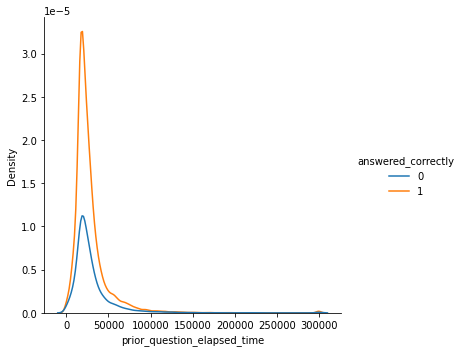

In [66]:
sns.displot(data=df_train, x='prior_question_elapsed_time', hue='answered_correctly', kind='kde')
plt.show()

In [67]:
pd.crosstab(df_train.answered_correctly, df_train.prior_question_had_explanation)

prior_question_had_explanation,False,True
answered_correctly,,
0,419,20403
1,778,49727


In [69]:
df_test.columns

Index(['user_id', 'content_id', 'task_container_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'question_id', 'bundle_id', 'part', 'tags', 'tag_count',
       'user_ques_acc', 'user_bundle_acc', 'user_tags_acc', 'user_part_acc',
       'ques_acc'],
      dtype='object')

In [70]:
# Drop all the id columns
df_train.drop(columns=['user_id', 'content_id', 'task_container_id', 'question_id',
                       'bundle_id', 'part', 'tags', 'tag_count'], inplace=True)

df_test.drop(columns=['user_id', 'content_id', 'task_container_id', 'question_id',
                      'bundle_id', 'part', 'tags', 'tag_count'], inplace=True)

In [71]:
# Inspect the df_train
df_train.head()

,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc
0,1,0.0,False,1.0,1.0,0.580078,0.649902,0.649902,1.000000
1,1,23000.0,False,1.0,1.0,1.000000,0.790039,0.930176,0.919922
2,0,19000.0,False,0.0,0.0,0.660156,0.649902,0.649902,0.669922
3,1,30000.0,False,1.0,1.0,0.620117,0.649902,0.649902,0.549805
4,1,31000.0,False,1.0,1.0,0.620117,0.649902,0.649902,1.000000


In [72]:
# Inspect the df_train
df_test.head()

,prior_question_elapsed_time,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,ques_acc
0,0.0,False,0.0,0.0,0.000000,0.000000,0.500000
1,19000.0,True,1.0,1.0,0.720215,0.790039,1.000000
2,17000.0,True,0.0,0.0,0.000000,0.540039,1.000000
3,23000.0,True,0.0,0.0,0.709961,0.729980,0.799805
4,72400.0,True,0.0,0.0,0.000000,0.449951,0.500000


In [75]:
# Convert the boolean values to 1 and 0
df_train.prior_question_had_explanation = df_train.prior_question_had_explanation.map({True: 1, False: 0})
df_test.prior_question_had_explanation = df_test.prior_question_had_explanation.map({True: 1, False: 0})

In [78]:
from sklearn.preprocessing import MinMaxScaler

def scale(train, test, columns_to_scale):
    '''
    Accepts train, validate, test and a list of columns to scale.
    Returns train, validate, and test with new scaled columns.
    '''
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    # Drop original columns.
    train.drop(columns=columns_to_scale, inplace=True)
    test.drop(columns=columns_to_scale, inplace=True)
    
    return train, test

In [80]:
scaled_train, scaled_test = scale(df_train, df_test, ['prior_question_elapsed_time'])

In [82]:
scaled_train.describe()

,answered_correctly,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc,prior_question_elapsed_time_scaled
count,71327.000000,71327.000000,71327.000000,71327.000000,71327.000000,71327.000000,71327.000000,71327.000000,71327.000000
mean,0.708077,0.983218,0.708008,0.708008,0.708008,0.707520,0.707520,0.708496,0.093726
std,0.454650,0.128454,0.403076,0.347168,0.238281,0.112488,0.105286,0.234741,0.079314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.500000,0.500000,0.580078,0.629883,0.629883,0.549805,0.056667
50%,1.000000,1.000000,1.000000,0.830078,0.740234,0.720215,0.740234,0.729980,0.073333
75%,1.000000,1.000000,1.000000,1.000000,0.879883,0.790039,0.779785,0.899902,0.104443
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
scaled_test.describe()

,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,ques_acc,prior_question_elapsed_time_scaled
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.961538,0.040100,0.040100,0.330566,0.619629,0.705566,0.082366
std,0.193239,0.185181,0.185181,0.389160,0.171997,0.262695,0.034060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.540039,0.560059,0.060000
50%,1.000000,0.000000,0.000000,0.000000,0.659912,0.719971,0.081112
75%,1.000000,0.000000,0.000000,0.700195,0.729980,1.000000,0.096042
max,1.000000,1.000000,1.000000,1.000000,0.910156,1.000000,0.241333


In [85]:
X_train = scaled_train.drop(columns='answered_correctly')
y_train = scaled_train['answered_correctly']

In [88]:
def estimator_report(model_type, data_type, y_train, y_pred):
    matrix = confusion_matrix(y_train, y_pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    d = {'model_type': model_type, 'data_type': data_type, 
        'accuracy': accuracy, 'precision': precision, 'recall': recall}
    return d

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score

In [89]:
# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'Ada Boost',
         'Gradient Boost',
         'Nearest Neighbors',
         'Naive Bays',
         'Neural Net'
        ]

In [92]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               KNeighborsClassifier(3),
               GaussianNB(), 
               MLPClassifier()
              ]

In [93]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [95]:
metrics = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    print(name)
    classifier = classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    d = estimator_report(name, 'train', y_train, y_pred)
    metrics = metrics.append(d, ignore_index=True)

metrics # The whole process took about 30 mins

LogisticRegression
Decision Tree
Random Forest
Ada Boost
Gradient Boost
Nearest Neighbors
Naive Bays
Neural Net


,accuracy,data_type,model_type,precision,recall
0,0.923886,train,LogisticRegression,0.937071,0.956757
1,0.921544,train,Decision Tree,0.911398,0.984952
2,0.918698,train,Random Forest,0.960982,0.922641
3,0.925049,train,Ada Boost,0.952323,0.941273
4,0.927657,train,Gradient Boost,0.938395,0.960915
5,0.940149,train,Nearest Neighbors,0.955563,0.960123
6,0.919147,train,Naive Bays,0.965284,0.918860
7,0.924461,train,Neural Net,0.920938,0.977210
